In [1]:
# Zdefiniowanie struktury
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

In [2]:
subtypes(Real)

4-element Vector{Any}:
 AbstractFloat
 AbstractIrrational
 Integer
 Rational

In [3]:
# Przeciążenie podstawowych operatorów
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
# Przeciążenie podstawowych funkcji
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

In [4]:
# Promocja typów i konwersja
import Base: convert, promote_rule

In [5]:
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[Dual{Float64}(1.0, 2.0), Dual{Float64}(3.0, 0.0)]


In [6]:
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];

Dual{Float64}[1, 2, 3] = Dual{Float64}[Dual{Float64}(1.0, 0.0), Dual{Float64}(2.0, 0.0), Dual{Float64}(3.0, 0.0)]


In [7]:
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;

Dual(1, 2) * 3 = Dual{Int64}(3, 6)


In [8]:
Dual(1,2) ^ 2

Dual{Int64}(1, 4)

In [9]:
# Pomocne funkcje
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [10]:
ReLU(x) = max(zero(x), x)
σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)
ϵ = Dual(0., 1.)

(0.0) + [1.0ϵ]

In [11]:
f(x) = x^4
x = 0.4
f.(x .+ ϵ)

(0.02560000000000001) + [0.25600000000000006ϵ]

In [12]:
center_diff(f, x₀; Δx=1e-3) = ( f(x₀ + Δx) - f(x₀ - Δx) )/2Δx
f(x) = x^4

x = -1:0.1:+1

y = partials.(f.(x .+ ϵ));
ŷ = center_diff.(f, x; Δx=1e-1)


21-element Vector{Float64}:
 -4.040000000000002
 -2.9519999999999995
 -2.0799999999999996
 -1.3999999999999992
 -0.8879999999999997
 -0.5199999999999999
 -0.27199999999999996
 -0.12000000000000001
 -0.04000000000000002
 -0.008
  ⋮
  0.04000000000000002
  0.12000000000000001
  0.27199999999999996
  0.5199999999999999
  0.8879999999999997
  1.3999999999999992
  2.0799999999999996
  2.9519999999999995
  4.040000000000002

In [13]:
f(X) = 3

f (generic function with 1 method)

In [14]:
partials(f)

MethodError: MethodError: no method matching partials(::typeof(f))

Closest candidates are:
  partials(!Matched::Dual)
   @ Main c:\Users\mbili\Downloads\W03.ipynb:5


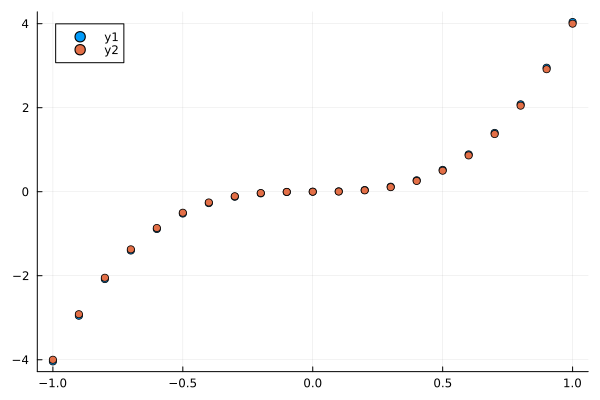

In [15]:
using Plots
#figure(figsize=(5,5), dpi=150)
s = scatter(x, ŷ, fillcolor  = :red)
scatter!(s, x, y, fillcolor  = :green)
#legend(("Central difference", "Automatic differentiation"))
#xlabel("x")
#ylabel("y")

In [16]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [17]:
x = [Dual(1, 0), Dual(1,1)]
f(x::Vector{Dual}) = x[1]^3 +x[1]*x[2] 

f (generic function with 2 methods)

In [18]:
partials.([f(x)...])

MethodError: MethodError: no method matching partials(::Int64)

Closest candidates are:
  partials(!Matched::Dual)
   @ Main c:\Users\mbili\Downloads\W03.ipynb:5


In [19]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            if i == j
                push!(x, Dual(args[j], one(args[j])))
            else
                push!(x, Dual(args[j], zero(args[j])))
            end
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [20]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end

hessian (generic function with 1 method)

In [21]:
n = 5.2
@show [n...];
v = [3.1,3.3]
@show [v...];
@show typeof(v);
@show typeof(v[:,:]);

[n...] = [5.2]
[v...] = [3.1, 3.3]
typeof(v) = Vector{Float64}
typeof(v[:, :]) = Matrix{Float64}


In [22]:
f(x) = x^3
f′(x) = derivative(f,  x)
f″(x) = derivative(f′, x)
f‴(x) = derivative(f″, x)
x = -1:0.1:+1

# using PyPlot
# figure(figsize=(5,5), dpi=150)
# plot(x,  f.(x))
# plot(x, f′.(x))
# plot(x, f″.(x))
# plot(x, f‴.(x))
# xlabel("x")
# ylabel("y")
# legend(("x^3", "3x^2", "6x", "6"))

-1.0:0.1:1.0

Działa dla funkcji jednej zmiennych, a czy na wielu zmiennych?

In [23]:
arr = [1.0, 2.3 ,3.3 ,4.1]
J(f,arr)

MethodError: MethodError: no method matching ^(::Vector{Dual{Float64}}, ::Int64)

Closest candidates are:
  ^(!Matched::Missing, ::Integer)
   @ Base missing.jl:165
  ^(!Matched::Missing, ::Number)
   @ Base missing.jl:123
  ^(!Matched::Irrational{:ℯ}, ::Integer)
   @ Base mathconstants.jl:119
  ...


In [24]:
f(x::Vector) = sin.(x) + tan.(x) + sqrt.(x);
J(f, [0.986403, 0.140913, 0.294963, 0.837125, 0.650451])

5×5 Matrix{Float64}:
 4.34065  0.0      0.0      0.0      0.0
 0.0      3.34218  0.0      0.0      0.0
 0.0      0.0      2.96976  0.0      0.0
 0.0      0.0      0.0      3.44641  0.0
 0.0      0.0      0.0      0.0      2.99476

In [31]:
f(x::Vector) = x[1]^2+x[2]^2+x[3]^2
H(f, [1, 2, 3])

3×3 Matrix{Int64}:
 2  0  0
 0  2  0
 0  0  2

Teraz sprawdzimy, czy działa liczenie jakobianu funkcji wektorowej:

In [32]:
f(x::Vector) = [2x[1]*x[2], 3x[2]*x[3]]
J(f, [1, 2., 3, 4, 5])

2×5 Matrix{Float64}:
 4.0  2.0  0.0  0.0  0.0
 0.0  9.0  6.0  0.0  0.0

Należy uważać na pomieszanie się $\epsilon$:

In [32]:
D(x -> x * D(y ->       x  + y, 1), 1) # == 1

2

Powyższy wynik jest niepoprawny, bo `x` z zewnętrznego domknięcia jest typu `Dual`:

In [33]:
D(x -> x * D(y -> value(x) + y, 1), 1) # == 1

1

Drugi przykład kodu, który nie robi tego, co byśmy chcieli:

In [34]:
D(x -> x * D(y -> x * y, 1), 4) # == 8

5

In [33]:
f(x::Vector) = x[1]*x[2]
j(x::Vector) = x[1]*J(f, x)
h(x::Vector) = J(j, x)
h([4., 1.])

2×2 Matrix{Float64}:
 1.0  4.0
 8.0  0.0

In [34]:
J((x[1]*J(f, x)), x)

MethodError: MethodError: no method matching jacobian(::typeof(f), ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})

Closest candidates are:
  jacobian(::Any, !Matched::Vector{T}) where T<:Number
   @ Main c:\Users\mbili\Downloads\W03.ipynb:1


Dzięki temu możemy liczyć różniczki bardziej zaawansowanych funkcji, np. funkcję aktywacji SoftMax:

In [37]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))

softmax(x)  =  exp.(x) ./ sum(exp.(x));
dsoftmax(x) = (softmax(x) |> diagonal) .- softmax(x) * (softmax(x) |> transpose);

In [38]:
J(softmax, [0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

In [39]:
dsoftmax([0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

No i jesteśmy w stanie nauczyć prostą sieć neuronową!

In [38]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
Wh  = randn(10,2)


10×2 Matrix{Float64}:
  0.540595  -1.08181
  0.793322   2.45498
  1.73769    1.1286
  0.558903   0.877003
  0.592738  -0.425518
 -0.886116  -1.04693
  1.87092    0.957768
  1.0769     0.660367
  0.231729   0.476237
  0.636457   0.475963

In [54]:
σ.([1,2])

2-element Vector{Float64}:
 0.7310585786300049
 0.8807970779778823

In [44]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
Wh  = randn(10,2)
Wo  = randn(1,10)
dWh = similar(Wh)
dWo = similar(Wo)
x = [1.98;4.434]
y = [0.064]
E = Float64[]

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 10, 2, x, σ)
    ŷ = fullyconnected(wo, 1, 10, x̂, u -> u)
    E = mean_squared_loss(y, ŷ)
end
Ei = net(x, Wh[:], Wo[:], y)

0.04898635403460071

Poniższe komórki można powtarzać wywołując kolejne epoki (chociaż uczymy tylko na jednych danych).

Poniżej zaimplementowana metoda najszybszego spadku: 
gradienty `dWh` i `dWo` wskazują gradienty, czyli kierunki
najszybszego **wzrostu** wartości funkcji błędu

In [60]:
w -> net(x, w, wo, y)

#33 (generic function with 1 method)

In [61]:
methods(w)

UndefVarError: UndefVarError: `w` not defined

In [51]:
dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y);

dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);
dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y);

push!(E, Ei)
Wh .-= 0.1dWh
Wo .-= 0.1dWo

Ei  = net(x, Wh[:], Wo[:], y)

7.887998074130448e-5

In [47]:
using Plots
plot(log10.(E), "s-")
xlabel("epoch")
ylabel("log10(loss function)")

ErrorException: Cannot convert String to series data for plotting

In [35]:
rosenbrock(x, y) = (1.0 - x)^2 + 100.0*(y - x*x)^2
v  = -1:.1:+1
n  = length(v)
xv = repeat(v, 1, n)
yv = repeat(v',n, 1)
dz = rosenbrock.(xv .+ ϵ, yv)
dzdx = partials.(dz)
dz = rosenbrock.(xv, yv .+ ϵ)
dzdy = partials.(dz)
z = value.(dz)

21×21 Matrix{Float64}:
 404.0   365.0   328.0   293.0   …  20.0   13.0    8.0    5.0     4.0
 331.22  296.02  262.82  231.62      8.02   4.82   3.62   4.42    7.22
 272.2   240.4   210.6   182.8       3.4    3.6    5.8   10.0    16.2
 224.9   196.1   169.3   144.5       4.1    7.3   12.5   19.7    28.9
 187.52  161.32  137.12  114.92      8.32  14.12  21.92  31.72   43.52
 158.5   134.5   112.5    92.5   …  14.5   22.5   32.5   44.5    58.5
 136.52  114.32   94.12   75.92     21.32  31.12  42.92  56.72   72.52
 120.5    99.7    80.9    64.1      27.7   38.9   52.1   67.3    84.5
 109.6    89.8    72.0    56.2      32.8   45.0   59.2   75.4    93.6
 103.22   84.02   66.82   51.62     36.02  48.82  63.62  80.42   99.22
 101.0    82.0    65.0    50.0   …  37.0   50.0   65.0   82.0   101.0
 102.82   83.62   66.42   51.22     35.62  48.42  63.22  80.02   98.82
 108.8    89.0    71.2    55.4      32.0   44.2   58.4   74.6    92.8
 119.3    98.5    79.7    62.9      26.5   37.7   50.9   66.1 

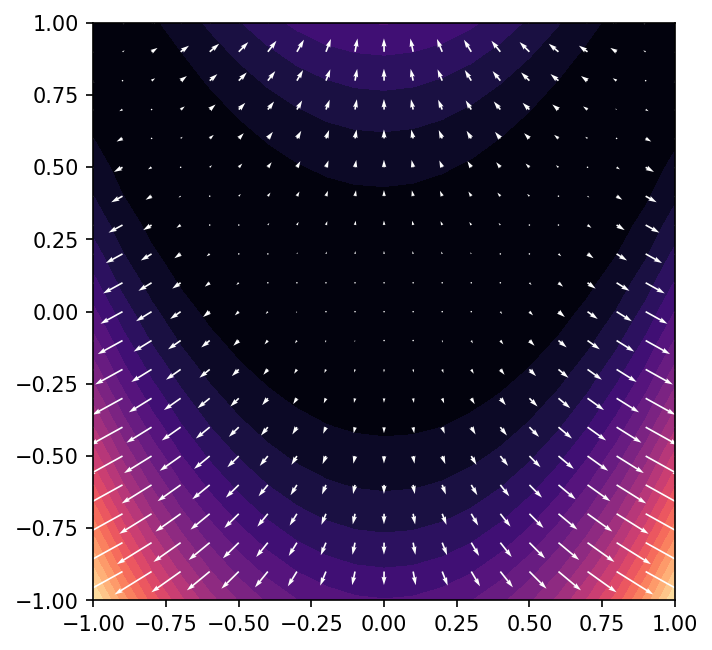

PyObject <matplotlib.quiver.Quiver object at 0x138163e20>

In [36]:
using PyPlot
figure(figsize=(5, 5), dpi=150)
contourf(xv, yv, z, levels=20, cmap="magma")
quiver(xv, yv, dzdx, dzdy, color="white")

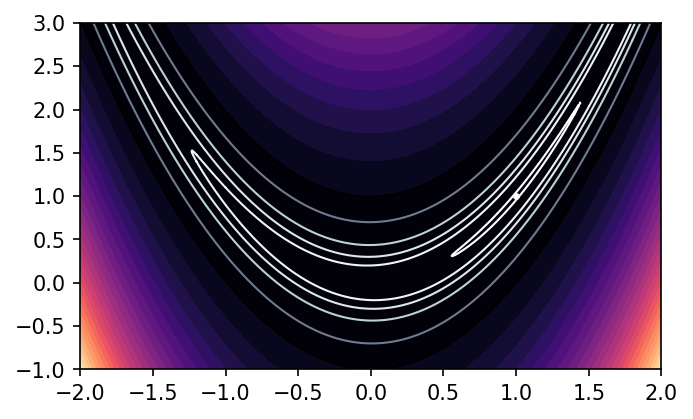

PyObject <matplotlib.collections.PathCollection object at 0x137da7c40>

In [37]:
u  = -2:.01:+2
v  = -1:.01:+3

xv = repeat(u, 1, length(v))
yv = repeat(v',length(u), 1)
 z = rosenbrock.(xv, yv)

figure(figsize=(5, 3), dpi=150)
contourf(xv, yv, z, levels=30, cmap="magma")
contour(xv, yv, z, levels=[0.2, 5.0, 10.0, 20.0, 50.0, 100.0], linewidths=[1], linestyles=["-"], cmap="bone" * "_r")
scatter([1.0], [1.0], s=5, marker="o", c="white")